### Introduction

Contining on Part 3 of this demo series, we will focus on CF ensemble as a stacker on top of other ensemble learning methods; e.g., stacking upon stacking. 
- Stacking upon stacking works by using a meta-learner such as logistic regression to make an initial label prediciton on `T` followed by CF ensemble method to reestimate probabilities. 
- Motivation: CF methods are greatly affected by the labeling guess on the test split (`T`)
  - Majority vote does not always result in "sufficient" accuracy for TPs, leading to a degradation of the "qualify" of the reestimated matrices, where the quality in this context is evaluated by how well the reestimatation can be used to predict the test or unseen data just like the regular classification settings. 
  - kNN-based mehtods do not always perform well either

Reference
---------
1. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import os, sys

# Colab 
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Plotting
import matplotlib.pylab as plt
# %matplotlib inline

from matplotlib.pyplot import figure
import seaborn as sns
from IPython.display import display

# Progress
from tqdm import tqdm

################################################################
# Configure system environment
# - Please modify input_dir according to your local enviornment
#
################################################################

cur_dir = os.getcwd()
project_dir = 'machine_learning_examples/cf_ensemble'
if IN_COLAB: 
    # Run this demo on Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Parameters for data
    input_dir = f"/content/drive/MyDrive/Colab Notebooks/{project_dir}"
    # /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/data/data-is-life

    sys.path.append(input_dir)
else: 
    input_dir = cur_dir
    
if input_dir != cur_dir: 
    sys.path.append(input_dir)
    print(f"> Adding {input_dir} to sys path ...")
    print(sys.path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
> Adding /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble to sys path ...
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble', '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble']


In [2]:
# Tensorflow
import tensorflow as tf
print(tf.__version__)
# import tensorflow_probability as tfp
# tfd = tfp.distributions
from tensorflow import keras

# from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
#################################################################

# Scikit-learn 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#################################################################

# CF-ensemble-specific libraries
import utils_stacking as ustk
import utils_classifier as uclf
import utils_sys as usys
import utils_cf as uc 
import polarity_models as pmodel
from polarity_models import Polarity
import scipy.sparse as sparse
from utils_sys import highlight
#################################################################

# Misc
import pprint
import tempfile
from typing import Dict, Text

np.set_printoptions(precision=3, edgeitems=5, suppress=True)

2.8.0


### Generating training data

> n_classes: 2
[0 1]

> counts:
Counter({0: 3697, 1: 1303})



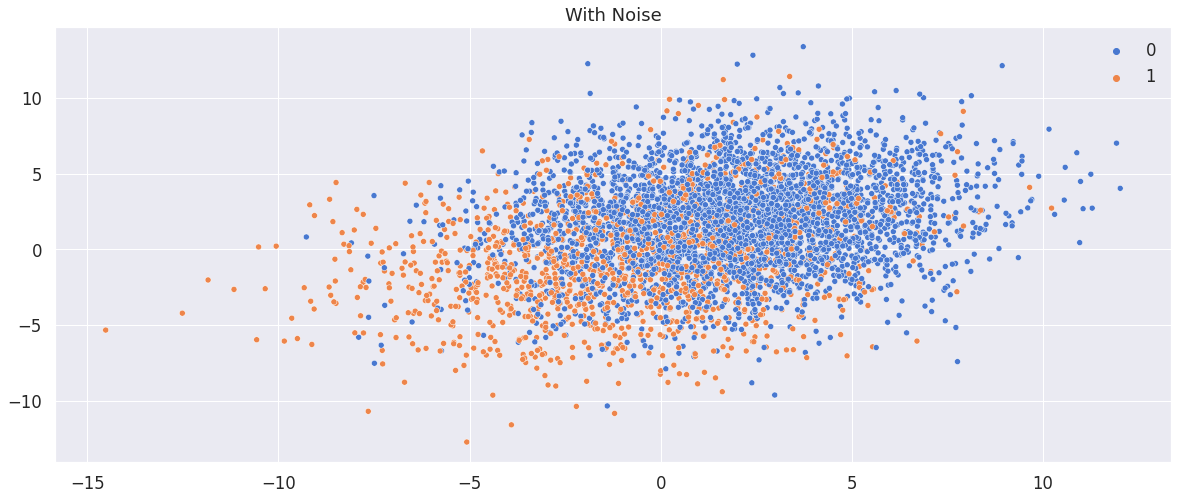

In [3]:
%matplotlib inline
import data_pipeline as dp

max_class_ratio=0.80

# get the dataset
X0, y0 = dp.generate_imbalanced_data(class_ratio=max_class_ratio, verbose=1)

### Choosing base classifiers

In [4]:
# Create Base Learners
base_learners = [
                 ('RF', RandomForestClassifier(n_estimators= 200, 
                                                   oob_score = True, 
                                                   class_weight = "balanced", 
                                                   random_state = 20, 
                                                   ccp_alpha = 0.1)), 
                 ('KNNC', KNeighborsClassifier(n_neighbors = len(np.unique(y0))
                                                     , weights = 'distance')),
                #  ('SVC', SVC(kernel = 'linear', probability=True,
                #                    class_weight = 'balanced'
                #                   , break_ties = True)), 

                 ('GNB', GaussianNB()), 
                 ('QDA',  QuadraticDiscriminantAnalysis()), 
                 ('MLPClassifier', MLPClassifier(alpha=1, max_iter=1000)), 
                 # ('DT', DecisionTreeClassifier(max_depth=5)),
                 # ('GPC', GaussianProcessClassifier(1.0 * RBF(1.0))),
                ]

### Load pre-trained level-1 data
- If it's unclear how to obtain the pre-trained dataset (e.g. probability matrices from base classifiers), please refer back to **part 1** or **part 2** of this demo series. 

In [5]:
import cf_models as cm

tLoadPretrained = False
######################
fold_number = 0
n_iterations = 1
data_dir = os.path.join(input_dir, 'data')
######################

if not tLoadPretrained:  
    # Use the previously selected base predictors (`base_learners`) to generate the level-1 dataset
    R, T, U, L_train, L_test = cm.demo_cf_stacking(input_data=(X0, y0), 
                                                   input_dir=input_dir, n_iter=n_iterations, 
                                                   base_learners=base_learners, # <<< base classifiers selected
                                                   verbose=1)
else: 
    R, T, U, L_train, L_test = dp.load_pretrained_level1_data(fold_number=fold_number, verbose=1, data_dir=data_dir)

# Derived quantities
n_train = R.shape[1]
p_threshold = uc.estimateProbThresholds(R, L=L_train, pos_label=1, policy='fmax')

2.8.0


  0%|          | 0/1 [00:00<?, ?it/s]

(BaseCF) base est | name: RF, estimator: RandomForestClassifier(ccp_alpha=0.1, class_weight='balanced', n_estimators=200,
                       oob_score=True, random_state=20)
(BaseCF) base est | name: KNNC, estimator: KNeighborsClassifier(n_neighbors=2, weights='distance')
(BaseCF) base est | name: GNB, estimator: GaussianNB()
(BaseCF) base est | name: QDA, estimator: QuadraticDiscriminantAnalysis()
(BaseCF) base est | name: MLPClassifier, estimator: MLPClassifier(alpha=1, max_iter=1000)
(BaseCF) Base predictors:
[1]  RF: RandomForestClassifier(ccp_alpha=0.1, class_weight='balanced', n_estimators=200,
                       oob_score=True, random_state=20)
[2]  QDA: QuadraticDiscriminantAnalysis()
[3]  MLPClassifier: MLPClassifier(alpha=1, max_iter=1000)
[4]  KNNC: KNeighborsClassifier(n_neighbors=2, weights='distance')
[5]  GNB: GaussianNB()




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[info] Saving X_meta (shape=(3750, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/train-0.npz



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.1s finished


[info] Saving X_meta (shape=(1250, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz

[info] Saving X_meta (shape=(1250, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz

[result] 0.7836456558773425
(cf_write) Adding new attribute y:
[1 0 1 1 1 ... 1 0 1 1 0]
...
(cf_write) Saving X_meta at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz



100%|██████████| 1/1 [01:17<00:00, 77.32s/it]

[info] list of base classifiers:
['RF' 'KNNC' 'GNB' 'QDA' 'MLPClassifier']

R: Rating/probability matrix for the TRAIN set


### Using stacking to make the first labeling prediction on test set

In [6]:
from collections import namedtuple
from sklearn.metrics import f1_score

alpha = 100
n_factors = 100
policy_threshold = 'fmax'
conf_measure = 'brier'
scoring_fn = f1_score

stacker = RandomForestClassifier(oob_score=True)
grid = uclf.hyperparameter_template(model='rf')

# A CF ensemble dataset consists of several parts: original (rating) matrix, re-estimated matrix, ...
# - namedtuple comes in handy
DataSet = namedtuple("DataSet", "X, Xh, L") # declare a `DataSet` type with the attributes: X, Xh and L
Hyperparams = namedtuple("Hyperparams", "alpha, n_factors, policy_threshold, conf_measure")

# The objects associated with traing split, hyperparameters are invariant across different prediction strategies
####################################################
meta = Hyperparams(policy_threshold=policy_threshold,
                   conf_measure=conf_measure, 
                   alpha=alpha, n_factors=n_factors)
train_split = DataSet(X=R, Xh=None, L=L_train)
test_split = DataSet(X=T, Xh=None, L=None)
####################################################

# Instead of using majority vote ... 
# lh = uc.estimateLabels(T, p_th=p_threshold) # We cannot use L_test (cheating), but we have to guesstimate

# ... Use another stacker
lh = lh_stacking = uc.estimateLabelsByStacking(stacker, grid, train_split, test_split, verbose=10)
perf_score = scoring_fn(L_test, lh)
acc_stacking = np.sum(lh == L_test) / (len(L_test)+0.0)
print(f'> [1] Labeling score ({scoring_fn.__name__}):  {perf_score}')
print(f"> [1] Labeling accuracy: {acc_stacking}")

L = np.hstack((L_train, lh)) 
X = np.hstack((R, T))

assert len(U) == X.shape[0]
print(f"> shape(R):{R.shape} || shape(T): {T.shape} => shape(X): {X.shape}")

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best: 0.797374 using {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}
0.796427 (0.020901) with: {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.797238 (0.021693) with: {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
0.797374 (0.022689) with: {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}
0.797124 (0.022147) with: {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}
0.796064 (0.022316) with: {'bootstrap': True, 'max_d

In [7]:
def f_score(precision, recall, beta=1.0):
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) 
    return f_beta
# from common import f_score

# workflow: p_threshold -> lh (est. labels) -> color matrix
Pc_stacking, Lh0 = pmodel.color_matrix(T, lh_stacking, p_threshold) # Mc: Color matrix evaluated via estimated labels 
Pf_stacking = pmodel.to_preference(Pc_stacking, neutral=0.0)
# => {TP, TN}-entries are desirable and thus encoded as 1s in `Pf_stacking` whereas {FP, FN}-entries are not desirable and encoded as 0s
metrics = pmodel.eval_estimated_probability_filter(Pf_stacking, T, L_test, p_threshold, eps=1e-3)

highlight("Guesstimated labeling (on T) via STACKING")
print(f"> Labeling accuracy: {acc_stacking}")
print(f"> Reliable-to-correct ratio: {metrics['p_overlap']}") # Fraction of entries predicted reliable and are actually correct (TPs or TNs)
print(f"> Precision: {metrics['precision']}, Recall: {metrics['recall']}")
print(f"> Predcitio(TP): {metrics['precision_tp']}, Recall(TP): {metrics['recall_tp']} => f1(TP): {f_score(metrics['precision_tp'], metrics['recall_tp'])}")
print(f"> Error rate: {metrics['p_missed']}") # Probability of predicting reliable but hitting either FPs or FNs

# How does it fair with majority vote? 
###############################################
# labeling by majority vote
lh_max_vote = uc.estimateLabels(T, p_th=p_threshold, pos_label=1)
acc_max_vote = np.sum(lh_max_vote == L_test) / (len(L_test)+0.0)
Pc_maxvote, Lh0 = pmodel.color_matrix(T, lh_max_vote, p_threshold) # Mc: Color matrix evaluated via estimated labels 
Pf_maxvote = pmodel.to_preference(Pc_maxvote, neutral=0.0)
# => {TP, TN}-entries are desirable and thus encoded as 1s in `Pf_maxvote` whereas {FP, FN}-entries are not desirable hence encoded as 0s
metrics = pmodel.eval_estimated_probability_filter(Pf_maxvote, T, L_test, p_threshold, eps=1e-3)

highlight("Guesstimated labeling (on T) via MAJORITY VOTE")
print(f"> Labeling accuracy: {acc_max_vote}")
print(f"> Reliable-to-correct ratio: {metrics['p_overlap']}") # Fraction of entries predicted reliable and are actually correct (TPs or TNs)
print(f"> Precision: {metrics['precision']}, Recall: {metrics['recall']}")
print(f"> Predcitio(TP): {metrics['precision_tp']}, Recall(TP): {metrics['recall_tp']} => f1(TP): {f_score(metrics['precision_tp'], metrics['recall_tp'])}")
print(f"> Error rate: {metrics['p_missed']}") # Probability of predicting reliable but hitting either FPs or FNs

Guesstimated labeling (on T) via STACKING
> Labeling accuracy: 0.9016
> Reliable-to-correct ratio: 0.9016
> Precision: 0.9008972101253979, Recall: 0.9773542905070284
> Predcitio(TP): 0.2050331242619734, Recall(TP): 0.9147076460333803 => f1(TP): 0.3349799729147497
> Error rate: 1.9333315539882654e-05
Guesstimated labeling (on T) via MAJORITY VOTE
> Labeling accuracy: 0.9
> Reliable-to-correct ratio: 0.9
> Precision: 0.8997658151782731, Recall: 0.9765077298396339
> Predcitio(TP): 0.20417312711132465, Recall(TP): 0.911226360986631 => f1(TP): 0.3335987466628177
> Error rate: 1.954640605841624e-05


### Training CFNet

[merge] Merging 'L_train' and 'lh': len(L_train): 3750 || len(lh): 1250 => len(L): 5000
[merge] Merging 'R' and 'T': shape(R):(5, 3750) || shape(T): (5, 1250) => shape(X): (5, 5000)

(make_cn) Using UNWEIGHTED confidence matrix (with all C[i][j] having equal weights) to approximate ratings ...
[info] Confidence matrix type: Cn, target data type: generic
Epoch 1/60
352/352 [==============================] - 4s 8ms/step - loss: 3.1512 - val_loss: 3.0281
Epoch 2/60
352/352 [==============================] - 3s 7ms/step - loss: 3.0770 - val_loss: 3.0184
Epoch 3/60
352/352 [==============================] - 3s 7ms/step - loss: 2.6735 - val_loss: 2.2531
Epoch 4/60
352/352 [==============================] - 3s 8ms/step - loss: 1.7694 - val_loss: 1.5178
Epoch 5/60
352/352 [==============================] - 3s 9ms/step - loss: 1.3445 - val_loss: 1.2380
Epoch 6/60
352/352 [==============================] - 3s 8ms/step - loss: 1.1878 - val_loss: 1.1641
Epoch 7/60
352/352 [========================

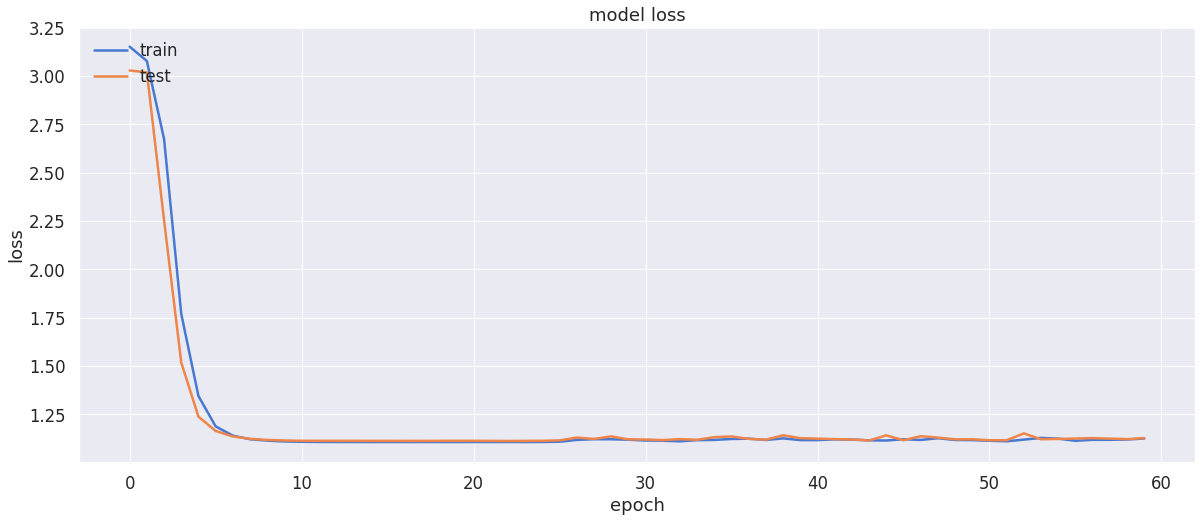

In [8]:
import cf_models as cm

n_users, n_items = X.shape

fold_number = 0
test_size = 0.1

policy_threshold = 'fmax'
conf_measure = 'brier'
n_factors = 100
alpha = 100

lr = 0.001 
batch_size = 64
epochs = 60 # Note: confidence_weighted_loss converges relatively faster compared to MSE, BCE etc.

loss_fn = cm.confidence_weighted_loss  # Options: cm.confidence_weighted_loss, cm.c_squared_loss, tf.keras.losses.BinaryCrossentropy(), tf.keras.losses.MeanSquaredError(), ...
cf_model = cm.get_cfnet_compiled(n_users, n_items, n_factors, loss=loss_fn, lr=lr)
# cf_model = cm.get_cfnet_approximating_labels(n_users, n_items, n_factors)

target_type = 'generic' # Options: 'generic', 'rating', 'label' 
# Which target type to choose? If we use MSE, then the model attempts to approximate ratings; 
# if we use BCE, then the model approximates the label
# Use `generic` for customized loss function with potentially more complex labeling information where "y_true" is a matrix 
conf_type = 'Cn' # Options: 'Cn', 'Cw', 'C0', or your customized weights

cf_model = cm.training_pipeline(input_model=(cf_model, loss_fn), 
                                input_data=(R, T, U, L_train, ), 
                                lh = lh_stacking, # supply the pre-computed estimated labels for T

                                # Should we combine R and T into a single matrix X? Set to True if so
                                is_cascade = True, # Set to True here to combine R and T into X 
                                
                                # SGD optimization parameters
                                test_size = test_size,
                                epochs = epochs, 
                                batch_size=batch_size, 

                                # CF hyperparameters
                                # n_factors=n_factors, # this is factored into model definition
                                alpha=alpha, 
                                conf_measure=conf_measure, 
                                policy_threshold=policy_threshold,

                                conf_type=conf_type, # default sparse confidence matrix (Cn)
                                target_type=target_type,
         
                                fold_number=fold_number)

In [9]:
Pc, _ = pmodel.color_matrix(X, L, p_th=p_threshold)
y_colors = pmodel.verify_colors(Pc)

In [10]:
analyzer = cm.analyze_reconstruction(cf_model, 
                                     X=(R, T),
                                     L=(L_train, lh_stacking), 
                                     Pc=Pc, p_threshold=p_threshold, policy_threshold=policy_threshold)
highlight("Reestimate the entire rating matrix (X) with learned latent factors/embeddings")
reestimated = analyzer(L_test, unreliable_only=False)
highlight("Reestimate ONLY the unreliable entries in X with learned latent factors/embeddings")
reestimated = analyzer(L_test, unreliable_only=True, verbose=2)

# Returned value `reestimated` is a dictionary with keys: `Rh`, `Th`, `ratings`, `p_threshold`

Reestimate the entire rating matrix (X) with learned latent factors/embeddings
[info] From R to Rh, delta(Frobenius norm)= 54.76161353050955
[info] From T to Th, delta(Frobenius norm)= 31.795177297271668
[info] How different are lh and lh_new? 0.2032
[result] Majority vote: F1 score with the original T:  0.7841105354058723
[result] Majority vote: F1 score with re-estimated Th using original p_threshold: 0.0
[result] Majority vote: F1 score with re-estimated Th: 0.4343257443082312

[result] Stacking: F1 score with the original T:  0.7848537005163511
[result] Stacking: F1 score with re-estimated Th: 0.41965973534971646

[result] Best settings (complete): lh_maxvote, score: 0.7841105354058723

Reestimate ONLY the unreliable entries in X with learned latent factors/embeddings
[info] From R to Rh, delta(Frobenius norm)= 18.668602871395876
[info] From T to Th, delta(Frobenius norm)= 4.4755610091287625
[info] How different are lh and lh_new? 0.0016
[result] Majority vote: F1 score with the or

### What if we tuned probability matrices even further using CFNet?

In [11]:
# A. Reestimate entire matrix
# Rh, Th = reestimate(model, X, n_train=n_train)
# B. Reestimate only unreliable entries (better)
# Rh, Th = reestimate_unreliable_only(model, X, Pc=Pc, n_train=n_train)
reestimated = analyzer(L_test, unreliable_only=True)
R2, T2 = reestimated['ratings'] # 
p_threshold2 = reestimated['p_threshold2']

# ... Use another stacker
stacker = RandomForestClassifier(oob_score=True)
grid = uclf.hyperparameter_template(model='rf')

# New `R` and `T` but the labels, of course, remain the same
train_split = DataSet(X=R2, Xh=None, L=L_train)
test_split = DataSet(X=T2, Xh=None, L=None)

lh2 = lh_stacking = uc.estimateLabelsByStacking(stacker, grid, train_split, test_split, verbose=5)
perf_score = scoring_fn(L_test, lh2)
acc_stacking = np.sum(lh2 == L_test) / (len(L_test)+0.0)
print(f'> [2] Labeling score ({scoring_fn.__name__}):  {perf_score}')
print(f"> [2] Labeling accuracy: {acc_stacking}")

L2 = np.hstack((L_train, lh2)) 
X2 = np.hstack((R2, T2))


[info] From R to Rh, delta(Frobenius norm)= 18.668602871395876
[info] From T to Th, delta(Frobenius norm)= 4.4755610091287625
[info] How different are lh and lh_new? 0.0016
[result] Majority vote: F1 score with the original T:  0.7841105354058723
[result] Majority vote: F1 score with re-estimated Th using original p_threshold: 0.7841105354058723
[result] Majority vote: F1 score with re-estimated Th: 0.7882960413080895

[result] Stacking: F1 score with the original T:  0.7848537005163511
[result] Stacking: F1 score with re-estimated Th: 0.7882960413080895

[result] Best settings (unreliable only): lh2_maxvote_pth_adjusted, score: 0.7882960413080895

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best: 1.000000 using {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
1.000000 (0.000000) with: {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': Non

In [12]:
from common import f_score

# workflow: p_threshold -> lh -> color matrix
Pc_stacking2, Lh2 = pmodel.color_matrix(T2, lh2, p_threshold2) # Mc: Color matrix evaluated via estimated labels 
Pf_stacking2 = pmodel.to_preference(Pc_stacking2, neutral=0.0)
# => {TP, TN}-entries are desirable and thus encoded as 1s in `Tpf` whereas {FP, FN}-entries are not desirable and encoded as 0s

metrics = pmodel.eval_estimated_probability_filter(Pf_stacking2, T2, L_test, p_threshold2, eps=1e-3)

highlight("Guesstimated labeling (on T2) via STACKING")
print(f"> Labeling accuracy: {acc_stacking}")
print(f"> Reliable-to-correct ratio: {metrics['p_overlap']}") # Fraction of entries predicted reliable and are actually correct (TPs or TNs)
print(f"> Precision: {metrics['precision']}, Recall: {metrics['recall']}")
print(f"> Precision(TP): {metrics['precision_tp']}, Recall(TP): {metrics['recall_tp']} => f1(TP): {f_score(metrics['precision_tp'], metrics['recall_tp'])}")
# NOTE: Precision(TP) is defined as P(TP|reliable), i.e. probability of being TP given predicted "reliable" (in an average sense)
print(f"> Error rate: {metrics['p_missed']}") # Probability of predicting reliable but hitting either FPs or FNs


Guesstimated labeling (on T2) via STACKING
> Labeling accuracy: 0.9016
> Reliable-to-correct ratio: 0.9016
> Precision: 0.9019409467970303, Recall: 0.9946482755769929
> Precision(TP): 0.19159970020085337, Recall(TP): 0.9761287501033674 => f1(TP): 0.32032443129824273
> Error rate: 1.640878002982044e-05


#### Applying the same training pipeline given earlier using new rating matrices ...

[merge] Merging 'L_train' and 'lh': len(L_train): 3750 || len(lh): 1250 => len(L): 5000
[merge] Merging 'R' and 'T': shape(R):(5, 3750) || shape(T): (5, 1250) => shape(X): (5, 5000)

(make_cn) Using UNWEIGHTED confidence matrix (with all C[i][j] having equal weights) to approximate ratings ...
[info] Confidence matrix type: Cn, target data type: generic
Epoch 1/60
352/352 [==============================] - 4s 8ms/step - loss: 1.3778 - val_loss: 0.8082
Epoch 2/60
352/352 [==============================] - 3s 8ms/step - loss: 0.5374 - val_loss: 0.3329
Epoch 3/60
352/352 [==============================] - 3s 7ms/step - loss: 0.2259 - val_loss: 0.1473
Epoch 4/60
352/352 [==============================] - 3s 7ms/step - loss: 0.1059 - val_loss: 0.0777
Epoch 5/60
352/352 [==============================] - 2s 7ms/step - loss: 0.0621 - val_loss: 0.0528
Epoch 6/60
352/352 [==============================] - 3s 7ms/step - loss: 0.0481 - val_loss: 0.0454
Epoch 7/60
352/352 [========================

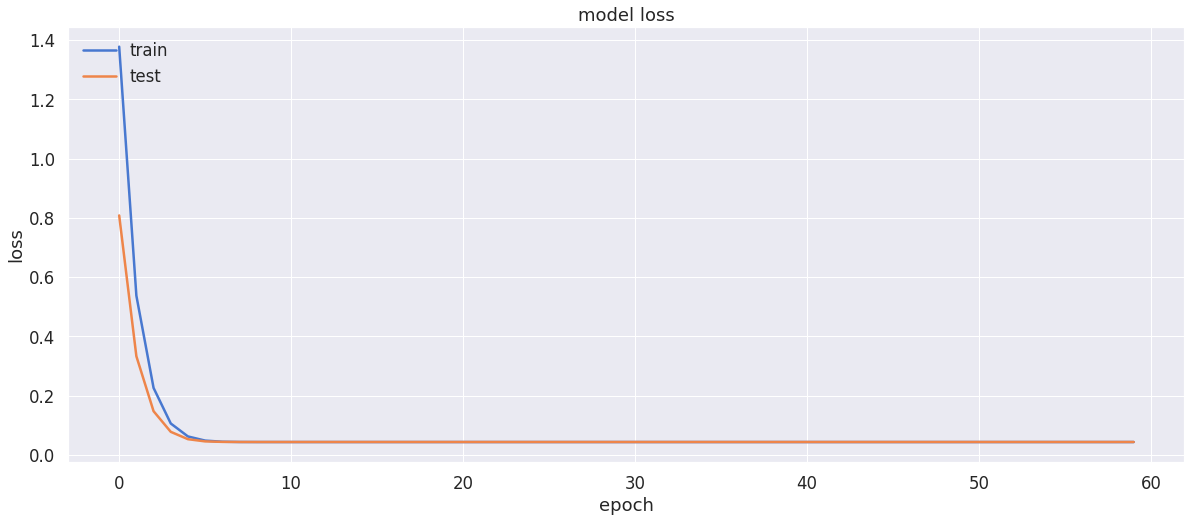

In [13]:
n_users, n_items = X.shape

# Uncomment previously-defined parameters below if needed
# fold_number = 0
# test_size = 0.1

# policy_threshold = 'fmax'
# conf_measure = 'brier'
# n_factors = 100
# alpha = 100

# lr = 0.001 
# batch_size = 64
# epochs = 60 # Note: confidence_weighted_loss converges relatively faster compared to MSE, BCE etc.

# target_type = 'generic' # Options: 'generic', 'rating', 'label' 
# conf_type = 'Cn' # Options: 'Cn', 'Cw', 'C0', or your customized weights

loss_fn = cm.confidence_weighted_loss # Options: cm.confidence_weighted_loss, cm.c_squared_loss, tf.keras.losses.BinaryCrossentropy(), tf.keras.losses.MeanSquaredError(), ...
cf_model = cm.get_cfnet_compiled(n_users, n_items, n_factors, loss=loss_fn, lr=lr)

cf_model = cm.training_pipeline(input_model=(cf_model, loss_fn), 
                                input_data=(R2, T2, U, L_train, ), 
                                lh = lh2, # supply the pre-computed estimated labels for T

                                # Should we combine R and T into a single matrix X? Set to True if so
                                is_cascade = True, # Set to True here to combine R and T into X 
                                
                                # SGD optimization parameters
                                test_size = test_size,
                                epochs = epochs, 
                                batch_size=batch_size, 

                                # CF hyperparameters
                                # n_factors=n_factors, # this is factored into model definition
                                alpha=alpha, 
                                conf_measure=conf_measure, 
                                policy_threshold=policy_threshold,

                                conf_type=conf_type, # default sparse confidence matrix (Cn)
                                target_type=target_type,
         
                                fold_number=fold_number)

In [14]:
Pc2, _ = pmodel.color_matrix(X2, L2, p_th=p_threshold2)
y_colors = pmodel.verify_colors(Pc2)

In [15]:
analyzer = cm.analyze_reconstruction(cf_model, 
                                     X=(R2, T2), 
                                     L=L2, 
                                     Pc=Pc2, 
                                     p_threshold=p_threshold2, policy_threshold=policy_threshold)
highlight("Reestimate the entire rating matrix (X) with learned latent factors/embeddings")
reestimated = analyzer(L_test, unreliable_only=False)
highlight("Reestimate ONLY the unreliable entries in X with learned latent factors/embeddings")
reestimated = analyzer(L_test, unreliable_only=True, verbose=2)

Reestimate the entire rating matrix (X) with learned latent factors/embeddings
[info] From R to Rh, delta(Frobenius norm)= 50.88565426082673
[info] From T to Th, delta(Frobenius norm)= 31.062169740108452
[info] How different are lh and lh_new? 0.2184
[result] Majority vote: F1 score with the original T:  0.7882960413080895
[result] Majority vote: F1 score with re-estimated Th using original p_threshold: 0.4635761589403973
[result] Majority vote: F1 score with re-estimated Th: 0.4161073825503356

[result] Stacking: F1 score with the original T:  0.7882960413080895
[result] Stacking: F1 score with re-estimated Th: 0.37476099426386233

[result] Best settings (complete): lh_maxvote, score: 0.7882960413080895

Reestimate ONLY the unreliable entries in X with learned latent factors/embeddings
[info] From R to Rh, delta(Frobenius norm)= 9.81270138047443
[info] From T to Th, delta(Frobenius norm)= 2.9647820215315743
[info] How different are lh and lh_new? 0.0
[result] Majority vote: F1 score w

Observation: The model at second CF-stacking iteration seems to have been "saturated" without being able to improve further

### Oracle: What if somehow we knew the true labels? 
- What's the max performance we can possibly get given a particular loss function? 

In [16]:
lh3 = L_test
L3 = np.hstack((L_train, L_test)) 
X3 = np.hstack((R, T)) # X3 is really identical to X (as we are using the original rating matrices)

In [17]:
# workflow: p_threshold -> lh -> color matrix
Pc_true, _ = pmodel.color_matrix(T, L_test, p_threshold) # Mc: Color matrix evaluated via estimated labels 
Pf_true = pmodel.to_preference(Pc_true, neutral=0.0)
metrics = pmodel.eval_estimated_probability_filter(Pf_true, T, L_test, p_threshold, eps=1e-3)

highlight("Guesstimated labeling (on T) via TRUE LABELS")
print(f"> Labeling accuracy: {1.0}")
print(f"> Reliable-to-correct ratio: {metrics['p_overlap']}") # Fraction of entries predicted reliable and are actually correct (TPs or TNs)
print(f"> Precision: {metrics['precision']}, Recall: {metrics['recall']}")
print(f"> Precision(TP): {metrics['precision_tp']}, Recall(TP): {metrics['recall_tp']} => f1(TP): {f_score(metrics['precision_tp'], metrics['recall_tp'])}")
# NOTE: Precision(TP) is defined as P(TP|reliable), i.e. probability of being TP given predicted "reliable" (estimate in an average sense)
print(f"> Error rate: {metrics['p_missed']}") # Probability of predicting reliable but hitting either FPs or FNs

Guesstimated labeling (on T) via TRUE LABELS
> Labeling accuracy: 1.0
> Reliable-to-correct ratio: 1.0
> Precision: 0.999999788359833, Recall: 0.999999788359833
> Precision(TP): 0.24317455170908958, Recall(TP): 0.9999991296787384 => f1(TP): 0.39121539284460577
> Error rate: 0.0


[merge] Merging 'L_train' and 'lh': len(L_train): 3750 || len(lh): 1250 => len(L): 5000
[merge] Merging 'R' and 'T': shape(R):(5, 3750) || shape(T): (5, 1250) => shape(X): (5, 5000)

(make_cn) Using UNWEIGHTED confidence matrix (with all C[i][j] having equal weights) to approximate ratings ...
[info] Confidence matrix type: Cn, target data type: rating
Epoch 1/100
352/352 [==============================] - 4s 8ms/step - loss: 3.4896 - val_loss: 3.2565
Epoch 2/100
352/352 [==============================] - 2s 7ms/step - loss: 3.5481 - val_loss: 3.2437
Epoch 3/100
352/352 [==============================] - 2s 7ms/step - loss: 3.5012 - val_loss: 2.6924
Epoch 4/100
352/352 [==============================] - 2s 7ms/step - loss: 2.4953 - val_loss: 1.8669
Epoch 5/100
352/352 [==============================] - 2s 7ms/step - loss: 1.6384 - val_loss: 1.3306
Epoch 6/100
352/352 [==============================] - 3s 7ms/step - loss: 1.2655 - val_loss: 1.1443
Epoch 7/100
352/352 [==================

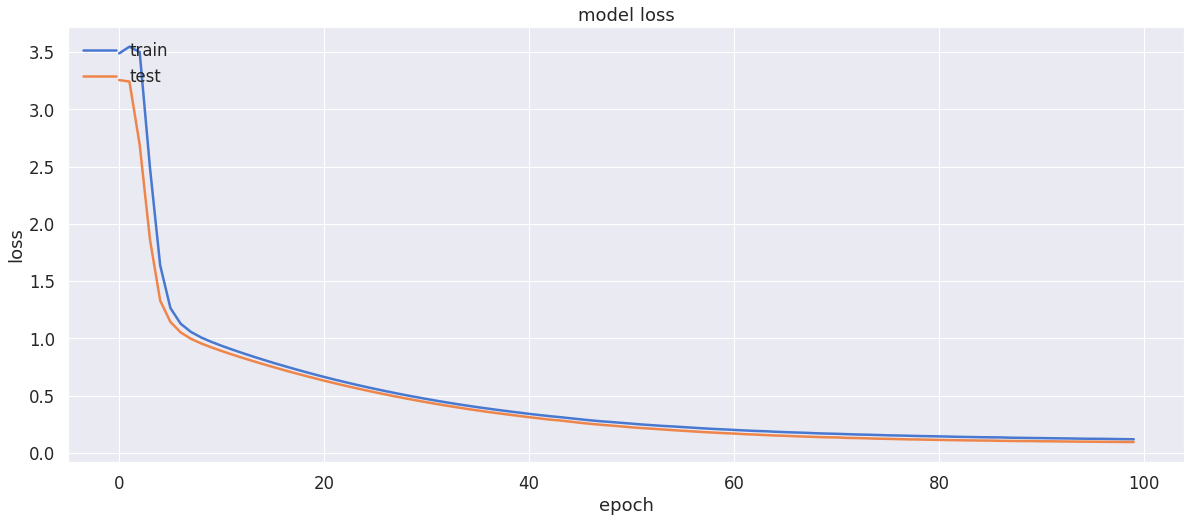

In [18]:
n_users, n_items = X.shape

# Uncomment previously-defined parameters below if needed
# fold_number = 0
# test_size = 0.1

# policy_threshold = 'fmax'
# conf_measure = 'brier'
# n_factors = 100
# alpha = 100

# lr = 0.001 
# batch_size = 64
target_type = 'rating' # Options: 'generic', 'rating', 'label' 
# conf_type = 'Cn' # Options: 'Cn', 'Cw', 'C0', or your customized weights

epochs = 100 # Note: confidence_weighted_loss converges relatively faster compared to MSE, BCE etc.

loss_fn = tf.keras.losses.MeanSquaredError() # Options: cm.confidence_weighted_loss, cm.c_squared_loss, tf.keras.losses.BinaryCrossentropy(), tf.keras.losses.MeanSquaredError(), ...
cf_model = cm.get_cfnet_compiled(n_users, n_items, n_factors, loss=loss_fn, lr=lr)

cf_model = cm.training_pipeline(input_model=(cf_model, loss_fn), 
                                input_data=(R, T, U, L_train, ), 
                                lh = L_test, # use true labels here and see what happens

                                # Should we combine R and T into a single matrix X? Set to True if so
                                is_cascade = True, # Set to True here to combine R and T into X 
                                
                                # SGD optimization parameters
                                test_size = test_size,
                                epochs = epochs, 
                                batch_size=batch_size, 

                                # CF hyperparameters
                                # n_factors=n_factors, # this is factored into model definition
                                alpha=alpha, 
                                conf_measure=conf_measure, 
                                policy_threshold=policy_threshold,

                                conf_type=conf_type, # default sparse confidence matrix (Cn)
                                target_type=target_type,
         
                                fold_number=fold_number)

In [19]:
Pc3, _ = pmodel.color_matrix(X3, L3, p_th=p_threshold) # L3 combines L_train and L_test (true labels); X3 is same as X = [R|T]
analyzer = cm.analyze_reconstruction(cf_model, 
                                     X=(R, T), 
                                     L=(L_train, L_test), 
                                     Pc=Pc3, 
                                     p_threshold=p_threshold, policy_threshold=policy_threshold)
highlight("Reestimate the entire rating matrix (X) with learned latent factors/embeddings")
reestimated = analyzer(L_test, unreliable_only=False)
highlight("Reestimate ONLY the unreliable entries in X with learned latent factors/embeddings")
reestimated = analyzer(L_test, unreliable_only=True, verbose=2)

Reestimate the entire rating matrix (X) with learned latent factors/embeddings
[info] From R to Rh, delta(Frobenius norm)= 43.9479123082168
[info] From T to Th, delta(Frobenius norm)= 24.853815575689307
[info] How different are lh and lh_new? 0.0992
[result] Majority vote: F1 score with the original T:  0.7841105354058723
[result] Majority vote: F1 score with re-estimated Th using original p_threshold: 0.8058608058608058
[result] Majority vote: F1 score with re-estimated Th: 0.9984686064318529

[result] Stacking: F1 score with the original T:  0.7848537005163511
[result] Stacking: F1 score with re-estimated Th: 0.9984686064318529

[result] Best settings (complete): lh2_maxvote_pth_adjusted, score: 0.9984686064318529

Reestimate ONLY the unreliable entries in X with learned latent factors/embeddings
[info] From R to Rh, delta(Frobenius norm)= 39.931365433921584
[info] From T to Th, delta(Frobenius norm)= 23.155564402799733
[info] How different are lh and lh_new? 0.0992
[result] Majority